## Text and Metadata extraction from PDF Files

Requirements
- Python 3.8 +
- PyMUPDF

Bear in mind that the top-level Python import name of the PyMuPDF library is fitz. We only work with searchable PDF files. To check whether your pdf file is legit, open it with a pdf reader and try to copy text or search for some words. A searchable pdf file enables you to do the mentioned work, while a scanned pdf cannot. The PyMuPDF library also cannot work with scanned pdf.

### Import necessary libraries

In [1]:
import fitz
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

In [2]:
## Local path to your file
path = "C:/Users/LENOVO/Desktop/Projects/Data Extraction/data/test.pdf"

Let’s open the pdf file with fitz:

In [3]:
doc = fitz.open(path)

The “doc” is a PyMuPDF’s Document class representing the whole document. We will get every necessary information from it, including the text. In case we get a multi-page document, we will loop all the pages to get the text plain from the document. Here is the result when we print the output:

In [4]:
for page in doc:
    text = page.get_text()
    print(text)

14
Model Validation and Veriﬁcation
14.1
Introduction
Whatever modelling paradigm or solution technique is being used, the performance mea-
sures extracted from a model will only have some bearing on the real system represented
if the model is a good representation of the system. Of course, what constitutes a good
model is subjective, but from a performance modelling point of view our criteria for judg-
ing the goodness of models will be based on how accurately measures extracted from the
model correspond to the measures which would be obtained from the represented system.
By its nature a model is more abstract than the system it represents (even a simulation
model). Viewed in one way, abstraction, and assumptions we make to achieve it, eliminate
unnecessary detail and allow us to focus on the elements within the system which are
important from a performance point of view; viewed in another way, this abstraction
process introduces inaccuracy. Some degree of inaccuracy may be necessary,

#### Blocks

The output is quite pretty since the PyMuPDF knows how to read the text in a natural order. However, what if you want to separate particular text blocks? It can be done by passing the parameter “blocks” to the get_text() method.

In [5]:
output = page.get_text("blocks")

The output is a list of tuple items, each item will look like this:

 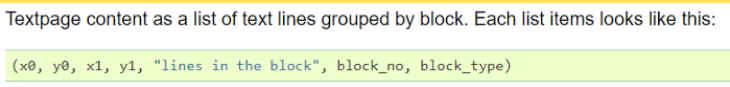
 
The x0, y0, x1, y1 is the coordinate of the text line in the document. The next element is the text itself. “block_no” is the block number and “block_type” indicate this block is a text or image.

From now we only care about the text and block number. All the blocks with the same block_no value will be grouped, so we can start printing the text as follow:

In [6]:
for page in doc:

    output, previous_block_id = page.get_text("blocks"), 0  # Set a variable to mark the block id             

    for block in output:

        if block[6] == 0: # We only take the text

            if previous_block_id != block[5]: # Compare the block number 

                print("\n")

            print(block[4])

14
Model Validation and Veriﬁcation



14.1
Introduction



Whatever modelling paradigm or solution technique is being used, the performance mea-
sures extracted from a model will only have some bearing on the real system represented
if the model is a good representation of the system. Of course, what constitutes a good
model is subjective, but from a performance modelling point of view our criteria for judg-
ing the goodness of models will be based on how accurately measures extracted from the
model correspond to the measures which would be obtained from the represented system.
By its nature a model is more abstract than the system it represents (even a simulation
model). Viewed in one way, abstraction, and assumptions we make to achieve it, eliminate
unnecessary detail and allow us to focus on the elements within the system which are
important from a performance point of view; viewed in another way, this abstraction
process introduces inaccuracy. Some degree of inaccuracy may be nece

#### Unicode

We might notice some strange symbols. This is because sometimesthe  we get text data in Unicode, but we need to represent it in ASCII. To fix this, we use Unidecode  library and pass the string into the unidecode function.

In [7]:
from unidecode import unidecode 

output = []
for page in doc:
    output += page.get_text("blocks")

previous_block_id = 0 # Set a variable to mark the block id

for block in output:
    if block[6] == 0: # We only take the text
        if previous_block_id != block[5]: # Compare the block number 
            print("\n")
        plain_text = unidecode(block[4])
        print(plain_text)

14
Model Validation and Verification



14.1
Introduction



Whatever modelling paradigm or solution technique is being used, the performance mea-
sures extracted from a model will only have some bearing on the real system represented
if the model is a good representation of the system. Of course, what constitutes a good
model is subjective, but from a performance modelling point of view our criteria for judg-
ing the goodness of models will be based on how accurately measures extracted from the
model correspond to the measures which would be obtained from the represented system.
By its nature a model is more abstract than the system it represents (even a simulation
model). Viewed in one way, abstraction, and assumptions we make to achieve it, eliminate
unnecessary detail and allow us to focus on the elements within the system which are
important from a performance point of view; viewed in another way, this abstraction
process introduces inaccuracy. Some degree of inaccuracy may be nec

#### Analyzing Text : Span

PyMuPDF lets you extract the text easily in a few lines of code. Frankly, we can achieve more by analyzing more properties of the text. For example, you want to know which line is bigger than the others, or whether the two blocks have the same font style or not. In this way, we can go deeper into what PyMuPDF can provide us.

Before starting, we should understand what “span” is. A span turns out to be an inline container that helps mark up a part of a text or a part of a document. In short, span is a small chunk of text. Every word in a span has the same size, text style, and font style. A document is a combination of many text blocks while a text block is composed of many spans.

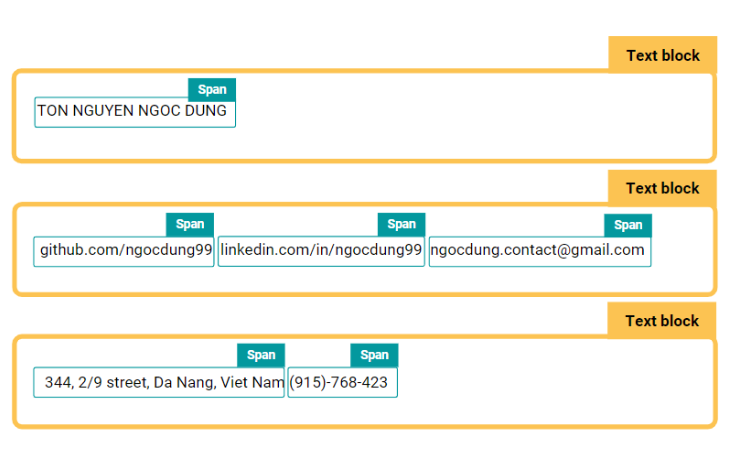

To get the spans from the PDF file, pass the parameter “dict” into the get_text() method of the doc object that we have before.

In [8]:
block_dict = {}

page_num = 1

for page in doc: # Iterate all pages in the document

    file_dict = page.get_text('dict') # Get the page dictionary 

    block = file_dict['blocks'] # Get the block information

    block_dict[page_num] = block # Store in block dictionary

    page_num += 1 # Increase the page value by 1

The “block_dict” is a dictionary containing detailed information of all spans in a document. Let’s retrieve the spans and store them in a DataFrame as follow:

In [9]:
spans, rows = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'text', 'tag']), []


for page_num, blocks in block_dict.items():
    
    for block in blocks:
        if block['type'] == 0:
            for line in block['lines']:
                for span in line['spans']:

                    xmin, ymin, xmax, ymax = list(span['bbox'])

                    font_size, text, span_font = span['size'], unidecode(span['text']), span['font']

                    is_upper, is_bold = False, False

                    if "bold" in span_font.lower():
                        is_bold = True 

                    if re.sub("[\(\[].*?[\)\]]", "", text).isupper():

                        is_upper = True

                    if text.replace(" ","") !=  "":

                        rows.append((xmin, ymin, xmax, ymax, text, is_upper, is_bold, span_font, font_size))

                        

span_df = pd.DataFrame(rows, columns=['xmin','ymin','xmax','ymax', 'text', 'is_upper','is_bold','span_font', 'font_size'])

Just a little insight, the code above tries to loop over the page, blocks, and lines in a document. Then we will get every span in a line. Although there are some properties in the spans, we care about the bbox (the bounding box), size, font, and text only.

In [10]:
span_df

,xmin,ymin,xmax,ymax,text,is_upper,is_bold,span_font,font_size
0,74.538002,87.529793,93.904877,104.762009,14,False,False,CMBX12,17.215
1,113.271751,87.529793,401.141022,104.762009,Model Validation and Verification,False,False,CMBX12,17.215
2,74.538002,121.445549,103.230003,135.805893,14.1,False,False,CMBX12,14.346
3,119.369263,121.445549,208.199677,135.805893,Introduction,False,False,CMBX12,14.346
4,74.538002,147.397797,528.074890,159.364746,Whatever modelling paradigm or solution techni...,False,False,CMR12,11.955
...,...,...,...,...,...,...,...,...,...
355,86.841919,715.158447,92.998741,727.113464,},False,False,CMTT12,11.955
356,74.537933,729.604431,80.694756,741.559448,},False,False,CMTT12,11.955
357,88.195923,766.941895,413.168701,778.908875,Figure 31: SimJava model demonstrating user-de...,False,False,CMR12,11.955
358,413.162933,766.964294,509.872437,778.919434,Queue Trace.java,False,False,CMTT12,11.955


#### Tags

We can create more features from these, such as finding the tag for the text. The tag is very significant since it gives you a helping hand in distinguishing between headings and content.

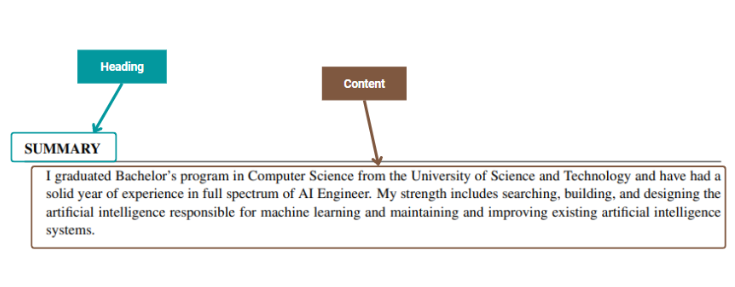

We will define three types of tag: h, p, and s.

- The ‘h’ tag denotes the text which is bigger and more important than normal paragraphs. The text with the ‘h’ tag is usually in the UPPER CASE and has the bold style.
- The ‘p’ tag stands for paragraph, or the normal content in the document. We can find the proper text with ‘p’ tag by counting the number of occurrences of each text size in a document, and then choose the text size which occurs most.
- The ‘s’ tag will be used for less important text, which is smaller than ‘p’ text.

Following this idea, we will start by gathering all the font sizes and styles in the span DataFrame. We will use the term “score” to emphasize the importance of a text span. The base score of each text span is the font size itself, and increase the score by 1 if it is in the upper case or has the bold style. Note that we also want to avoid increasing the score for the text with special symbols.

In [11]:
span_scores, span_num_occur, special = [], {}, '[(_:/,#%\=@)]'

for index, span_row in span_df.iterrows():

    score, text = round(span_row.font_size), span_row.text

    if not re.search(special, text):

        if span_row.is_bold:

            score +=1 

        if span_row.is_upper:

            score +=1

    span_scores.append(score)

values, counts = np.unique(span_scores, return_counts=True)

From this, we want to know the numer of unique text styles in the document, and the number of its occurrences. The method “unique” from NumPy can do easily. Make sure you install the NumPy library before this step.

In [12]:
values, counts = np.unique(span_scores, return_counts=True)

style_dict = {}

for value, count in zip(values, counts):

    style_dict[value] = count

sorted(style_dict.items(), key=lambda x: x[1])

[(17, 2), (14, 6), (12, 352)]

We got three text style and their number of occurrences respectively. Any text with the score 12 will be the normal paragraph since they appear frequently in the document, the others with scores (17,14) will be granted the h tag.

In [13]:
p_size, idx, tag = max(style_dict, key=style_dict.get), 0, {}

for size in sorted(values, reverse = True):
    idx += 1
    if size == p_size:

        idx, tag[size] = 0, 'p'

    if size > p_size:

        tag[size] = 'h{0}'.format(idx)

    if size < p_size:

        tag[size] = 's{0}'.format(idx)

In [14]:
tag

{17: 'h1', 14: 'h2', 12: 'p'}

From this, we’re able to create a new column in our span dataframe for the tag information.

In [15]:
span_tags = [tag[score] for score in span_scores]

span_df['tag'] = span_tags

In [16]:
span_df

,xmin,ymin,xmax,ymax,text,is_upper,is_bold,span_font,font_size,tag
0,74.538002,87.529793,93.904877,104.762009,14,False,False,CMBX12,17.215,h1
1,113.271751,87.529793,401.141022,104.762009,Model Validation and Verification,False,False,CMBX12,17.215,h1
2,74.538002,121.445549,103.230003,135.805893,14.1,False,False,CMBX12,14.346,h2
3,119.369263,121.445549,208.199677,135.805893,Introduction,False,False,CMBX12,14.346,h2
4,74.538002,147.397797,528.074890,159.364746,Whatever modelling paradigm or solution techni...,False,False,CMR12,11.955,p
...,...,...,...,...,...,...,...,...,...,...
355,86.841919,715.158447,92.998741,727.113464,},False,False,CMTT12,11.955,p
356,74.537933,729.604431,80.694756,741.559448,},False,False,CMTT12,11.955,p
357,88.195923,766.941895,413.168701,778.908875,Figure 31: SimJava model demonstrating user-de...,False,False,CMR12,11.955,p
358,413.162933,766.964294,509.872437,778.919434,Queue Trace.java,False,False,CMTT12,11.955,p


#### Text by headings 

That’s it. We’re now clear on which text is the headings and which one is the content in the document. This is very useful when extracting information since we want all paragraphs below a heading will be grouped. Let’s create a new dataframe where we can store the text by headings.

In [17]:
headings_list, text_list, tmp, heading = [], [], [], ''

for index, span_row in span_df.iterrows():

    text, tag = span_row.text, span_row.tag
    
    if 'h' in tag:

        headings_list.append(text)

        text_list.append('\n'.join(tmp))

        tmp, heading = [], text

    else:

        tmp.append(text)

text_list.append('\n'.join(tmp))

text_list = text_list[1:]

text_df = pd.DataFrame(zip(headings_list, text_list),columns=['heading', 'content'] )

In [18]:
text_df

,heading,content
0,14,
1,Model Validation and Verification,
2,14.1,
3,Introduction,Whatever modelling paradigm or solution techni...
4,14.2,
5,Model Verification,Verification is like debugging--it is intended...
6,14.3,
7,Model Validation,Validation is the task of demonstrating that t...
